In [1]:
import pandas as pd

nodes_df = pd.DataFrame(columns=['id', 'name', 'type'])
nodes_df.set_index('id', inplace=True)

edges_df = pd.DataFrame(columns=['source', 'target'])

In [2]:
from py2neo import Graph

NEO4J_USER = "neo4j" # replace with your login
NEO4J_PASS = "panamo" # replace with your password

url = 'http://localhost:7474'
graph = Graph(url + '/db/data', username = NEO4J_USER, password = NEO4J_PASS)

name_list = pd.read_csv('../01-Name Hunting/_selected_names.csv')
shuffled_names = name_list.sample(frac=1).reset_index(drop=True)
first_row = shuffled_names.iloc[0]
company_name = first_row["name"]
#company_name = "A.C. Futures Inc."
company_name

'Ningbo Hengjiu Lighting Co., Ltd.'

In [3]:
node_query = '''
        MATCH (a:Entity)-[r1]-(b)-[r2]-(c)
        WHERE a.name = {name}
        RETURN a, b, c
        '''

node_results = graph.run(node_query, name = company_name)


In [4]:
for nodes in node_results:
    for node in nodes:
        #row = {"id":int(node["node_id"]),"name": node["name"], "type": list(node.labels())[0]}
        label = list(node.labels())[0]
        name = node["name"] 
        nodes_df.loc[int(node["node_id"])] = {"name": name, "type": label}

nodes_df.iat[0,1] = 'Focus'
nodes_df.type = nodes_df.type.astype('category')

In [5]:
nodes_df.head()

,name,type
id,,
10013305,"Ningbo Hengjiu Lighting Co., Ltd.",Focus
12188942,LI SHENGHUI,Officer
14068630,None,Address
11001746,ORION HOUSE SERVICES (HK) LIMITED,Intermediary
10000016,"NINGBO RAPID INTERNATIONAL TRADING CO., LTD.",Entity


In [6]:
link_query = '''
        MATCH (a:Entity)-[r1]-(b)-[r2]-(c)
        WHERE a.name = {name}
        RETURN a.node_id, b.node_id, c.node_id
        '''

link_results = graph.run(link_query, name = company_name)

In [7]:
for l in link_results:
    a = int(l["a.node_id"])
    b = int(l["b.node_id"])
    c = int(l["c.node_id"])
    
    if ((edges_df['source'] == a) & (edges_df['target'] == b)).any() == False:
        edges_df.loc[len(edges_df)] = {"source": a, "target": b}
        
    if ((edges_df['source'] == b) & (edges_df['target'] == c)).any() == False:
        edges_df.loc[len(edges_df)] = {"source": b, "target": c}

edges_df = edges_df.apply(pd.to_numeric)

In [8]:
nodes = nodes_df
edges = edges_df

In [9]:
import math
import numpy as np
import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import random_layout, circular_layout, forceatlas2_layout
from datashader.bundling import connect_edges, hammer_bundle
from itertools import chain

In [10]:
cvsopts = dict(plot_height=1000, plot_width=1000)

def nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    return tf.spread(tf.shade(agg, cmap=["#333333"]), px=3, name=name)

def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name=name)

def graphplot(nodes, edges, name="", canvas=None, cat=None):
    if canvas is None:
        xr = nodes.x.min(), nodes.x.max()
        yr = nodes.y.min(), nodes.y.max()
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)
        
    np = nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(ep, np, how="over", name=name)

In [11]:
%time forcedirected = forceatlas2_layout(nodes, edges)
#tf.Images(nodesplot(forcedirected, "ForceAtlas2 layout"))

CPU times: user 37.2 s, sys: 56 ms, total: 37.2 s
Wall time: 37.3 s


CPU times: user 1.35 s, sys: 23.5 ms, total: 1.37 s
Wall time: 1.37 s
CPU times: user 765 ms, sys: 12.7 ms, total: 778 ms
Wall time: 777 ms
CPU times: user 16.9 s, sys: 1.53 s, total: 18.4 s
Wall time: 14 s
CPU times: user 10.8 s, sys: 2.98 s, total: 13.8 s
Wall time: 9.88 s


Circular layout,Force-directed
"Circular layout, bundled","Force-directed, bundled"

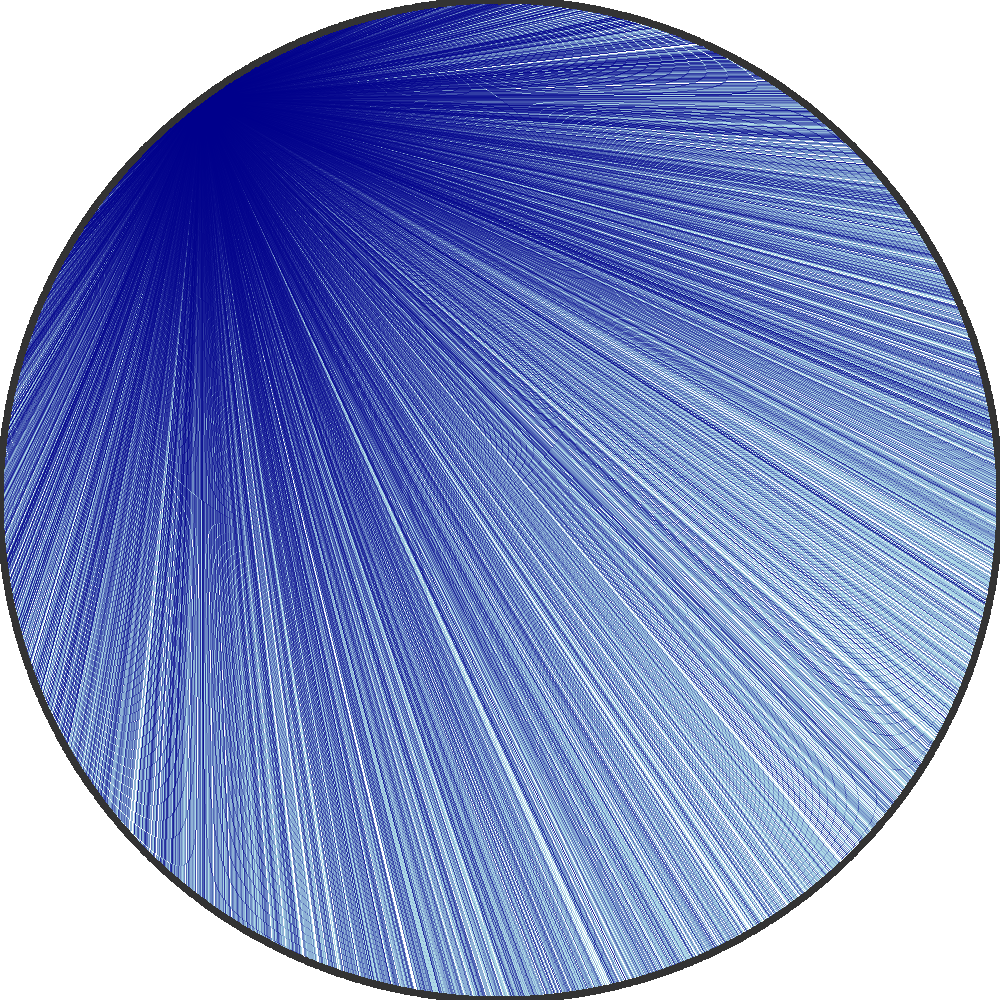
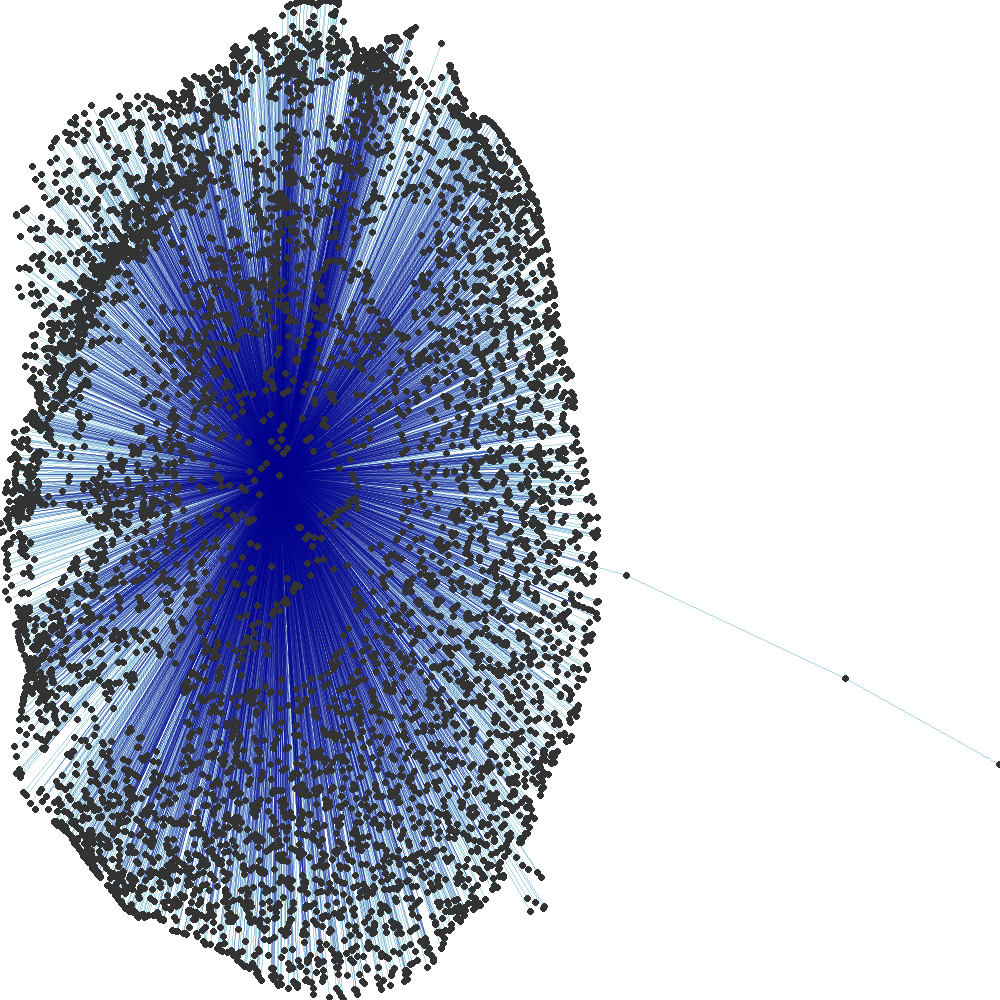
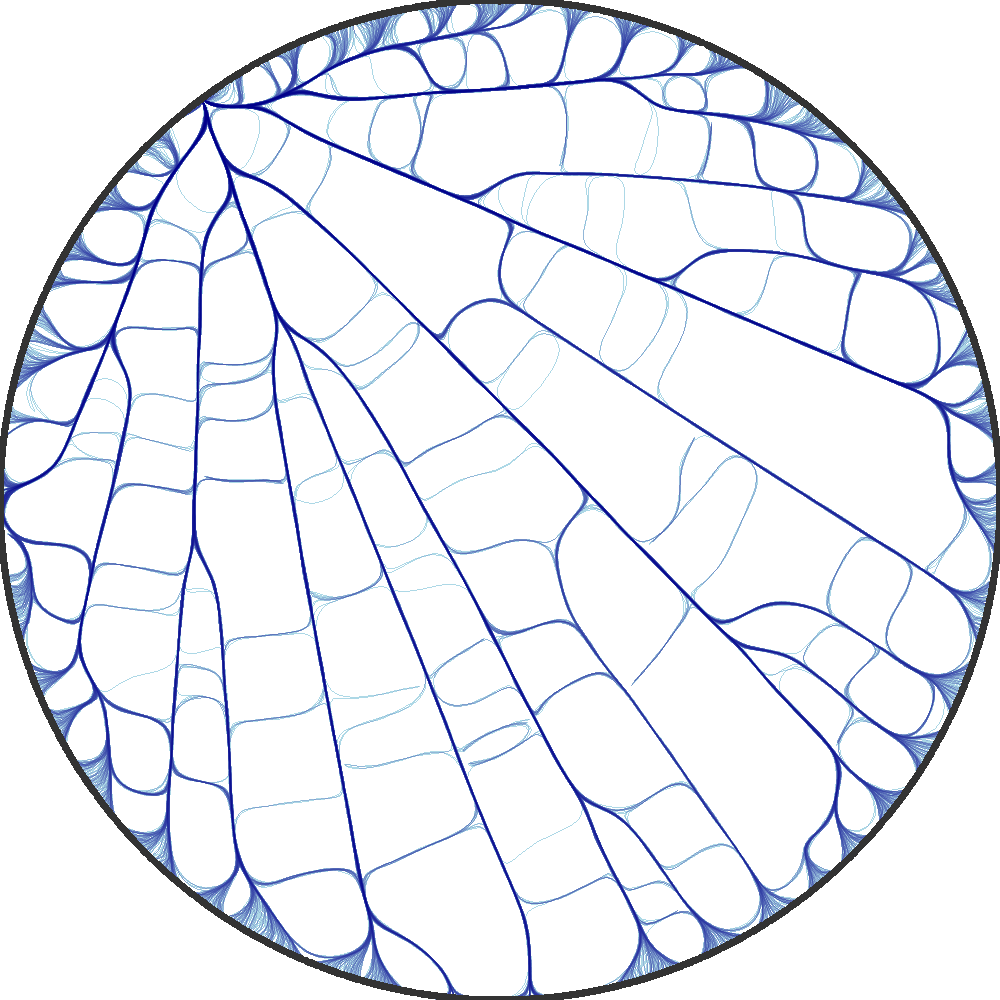
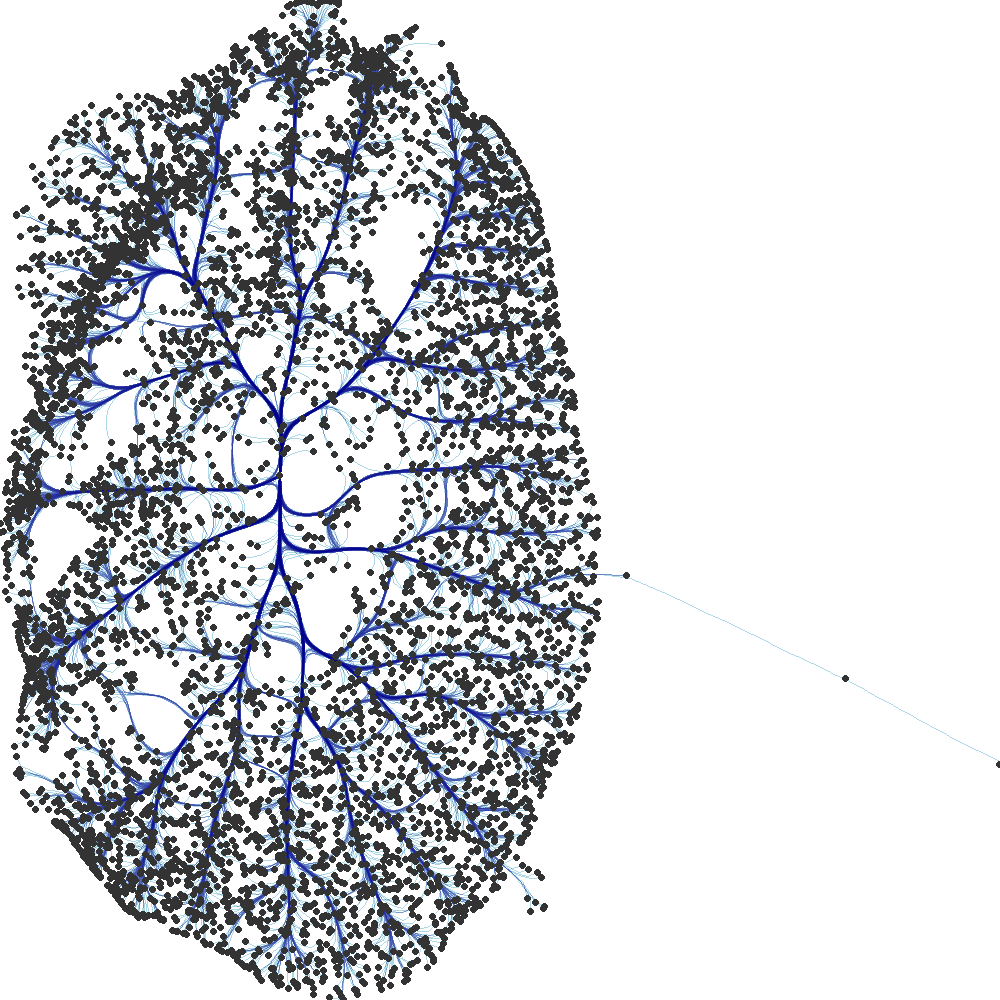

In [12]:
circular  = circular_layout(nodes, uniform=False)
cd = circular
fd = forcedirected

%time cd_d = graphplot(cd, connect_edges(cd,edges), "Circular layout")
%time fd_d = graphplot(fd, connect_edges(fd,edges), "Force-directed") 
%time cd_b = graphplot(cd, hammer_bundle(cd,edges), "Circular layout, bundled")
%time fd_b = graphplot(fd, hammer_bundle(fd,edges), "Force-directed, bundled") 

tf.Images(cd_d,fd_d,cd_b,fd_b).cols(2)

In [24]:
fd.iat[0,2] = 0.5 # center focus node on x
fd.iat[0,3] = 1 # center focus node on y

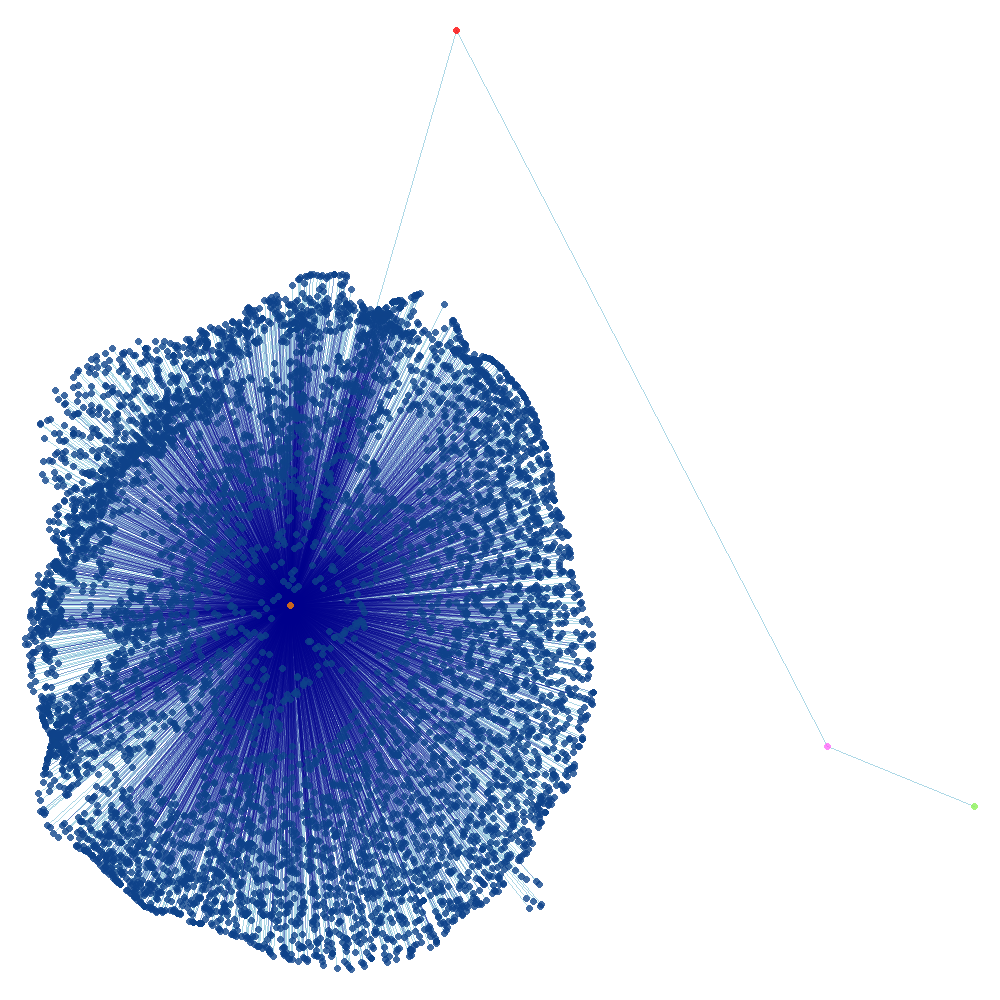

In [25]:
colors = {"Focus": "#FF0000", "Officer": "#ff69f9", "Entity": "#0e438a", "Address": "#8bf156", "Intermediary": "#ff8200"}


def my_nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    return tf.spread(tf.shade(agg, cmap=["#333333"], color_key=colors, min_alpha=200,), px=3, name=name)


def my_graphplot(nodes, edges, name="", canvas=None, cat=None, margin=0.05):
    if canvas is None:
        xr = nodes.x.min() - margin, nodes.x.max() + margin
        yr = nodes.y.min() - margin, nodes.y.max() + margin
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)
        
    np = my_nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(ep, np, how="over", name=name)

tf.Image(my_graphplot(fd, connect_edges(fd,edges), "Force-directed", cat="type", margin=0.02))